# Introduction to Time Series in Python

## Overview

- Time series is a sequence of data points ordered chronologically. Notice that we cannot randomly shuffle the data into trainig and test datasets. Instead, we split the datapoint by picking a cutoff time within the data.
- Each data point is associated with a timestamp.
- The interval between two data points is called **time-period**.
- **Frequency** refers to how often values a recorded ranging from milliseconds to years. We can adjust the frequency of a time-series by aggregating the data. We can decrease the frequency e.g. given a daily data, we can compute the averaged monthly. We can also increase the data by approximating or imputing datapoints between existing data points.
- Time periods between all data points must be equal i.e. have constant frequency. Otherwise we would have [missing values](https://stats.stackexchange.com/questions/121414/how-do-i-handle-nonexistent-or-missing-data). Dealing with missing values is complicated:

<img src="figures/time-series-missing-values.png" width="600" />

- Time series data does not satisfy [Gauss-Markov assumptions](https://www.statisticshowto.datasciencecentral.com/gauss-markov-theorem-assumptions/).
- Patterns observed in time series data in the past are expected to be present in the future.
- Data are usually **time-dependent**. This means that data points are affected by external factors and by the past periods. E.g. we expect tomorrows temperature outside to be within some reasonable proximity of the temperature today
- **Seasonality** refers to the periodic fluctuations of a time series in which the data contains regular and predictable changes. These patterns must be taken into account when making predictions. Seasonality is not a trait of cross-sectional data because there are no chronological order in these data.

<img src="figures/edited-apparel-seasonality.jpeg" width="600" />

Notation
- $\mathbf{X}$ denotes the data
- $T$ denotes the entire time span of the data
- $t$ a single period e.g. a single day
- $\mathbf{X}_t$ denotes the data for a single day

## Data Exploration

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df_data = pd.read_csv('data/Index2018.csv')

In [3]:
df_data.head()

,date,spx,dax,ftse,nikkei
0,07/01/1994,469.90,2224.95,3445.98,18124.01
1,10/01/1994,475.27,2225.00,3440.58,18443.44
2,11/01/1994,474.13,2228.10,3413.77,18485.25
3,12/01/1994,474.17,2182.06,3372.02,18793.88
4,13/01/1994,472.47,2142.37,3360.01,18577.26


In [4]:
df_data.dtypes

date       object
spx       float64
dax       float64
ftse      float64
nikkei    float64
dtype: object

Convert date to datetime type:

In [5]:
df_data.date = pd.to_datetime(df_data.date, dayfirst=True)

- Often dates are used as indices in time series data
- The data represents the closing prices for the four market indices:
  - **spx**: S&P 500 in US
  - **dax**: DAX 30 in Germany
  - **ftse**: FTSE 100 in the UK
  - **nikkei**: Nikkei 225 in Japan

Let us compute some statistics on the data:

In [6]:
df_data.describe()

,spx,dax,ftse,nikkei
count,6269.000000,6269.000000,6269.000000,6269.000000
mean,1288.127542,6080.063363,5422.713545,14597.055700
std,487.586473,2754.361032,1145.572428,4043.122953
min,438.920000,1911.700000,2876.600000,7054.980000
25%,990.671905,4069.350000,4486.100000,10709.290000
50%,1233.420000,5773.340000,5662.430000,15028.170000
75%,1459.987747,7443.070000,6304.250000,17860.470000
max,2872.867839,13559.600000,7778.637689,24124.150000


The average spx value is much lower than the other indices. The maximum spx value is lower than the minimum values of ftse and nikkei. We have take it into account if we need to compare multiple time series.

In [7]:
df_data.date.describe()

count                    6269
unique                   6269
top       1999-08-23 00:00:00
freq                        1
first     1994-01-07 00:00:00
last      2018-01-29 00:00:00
Name: date, dtype: object

The entire period of this dataset is from 7th January 1994 to 23th August 1999.

We need to set the date column as index and set the frequency of the time series to be daily:

In [8]:
df_data.set_index('date', inplace=True)

In [9]:
df_data.asfreq('d').head()

,spx,dax,ftse,nikkei
date,,,,
1994-01-07,469.90,2224.95,3445.98,18124.01
1994-01-08,NaN,NaN,NaN,NaN
1994-01-09,NaN,NaN,NaN,NaN
1994-01-10,475.27,2225.00,3440.58,18443.44
1994-01-11,474.13,2228.10,3413.77,18485.25


The `asfreq` method generated new periods where no values are associated.

In [10]:
from datetime import datetime

In [11]:
datetime.strptime('1994-01-08', '%Y-%M-%d').strftime('%c')

'Sat Jan  8 00:01:00 1994'

Closing prices of the indices are only recorded when the financial markets are open. 

To avoid adding irrelevant periods, we can state tell Pandas that the data was recorded on business days with `df.asfreq('b')`:

In [12]:
df_data = df_data.asfreq('b')

In [13]:
df_data.head()

,spx,dax,ftse,nikkei
date,,,,
1994-01-07,469.90,2224.95,3445.98,18124.01
1994-01-10,475.27,2225.00,3440.58,18443.44
1994-01-11,474.13,2228.10,3413.77,18485.25
1994-01-12,474.17,2182.06,3372.02,18793.88
1994-01-13,472.47,2142.37,3360.01,18577.26


### Missing Values

Let us determine the number of missing values.

In [14]:
df_data.isna().sum()

spx       8
dax       8
ftse      8
nikkei    8
dtype: int64

There are eight time periods with no values. There are various ways to fill the missing values:

- Front filling: use the value of the previous period to fill the period with the missing value i.e. copies the last known value
- Back filling: use the value of the next period to fill the period with the missing value.
- Assign the same value to all periods with missing value. You could use the average value of the time series for filling missing values. But this is a bad approach for time series data because there are underlying time varient patterns in the data. This method is only appropriate if the data fluctuates heavily around the mean for the entire period of the time series. The code:
  ```python
  df_data.dax = df_data.dax.fillna(value=df_data.dax.mean())
  ```

In [15]:
df_data.spx = df_data.spx.fillna(method='ffill')  # bfill for back filling
df_data.ftse = df_data.ftse.fillna(method='ffill')
df_data.dax = df_data.dax.fillna(method='ffill')
df_data.nikkei = df_data.nikkei.fillna(method='ffill')

In [16]:
df_data.isna().sum()

spx       0
dax       0
ftse      0
nikkei    0
dtype: int64

### Plotting

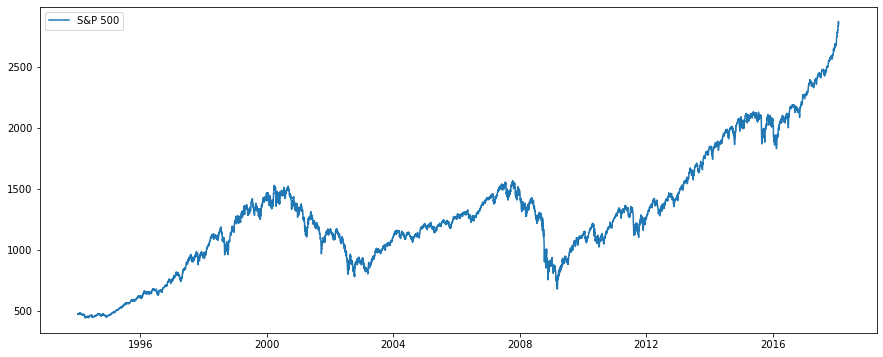

In [17]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(df_data.spx, label='S&P 500')
ax.legend();

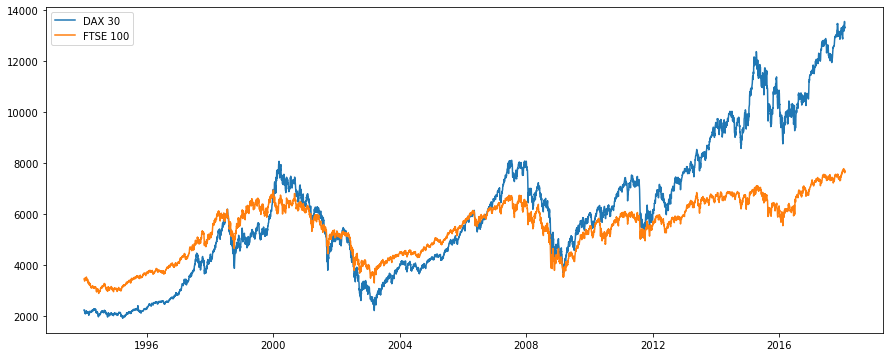

In [18]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(df_data.dax, label='DAX 30')
ax.plot(df_data.ftse, label='FTSE 100')
ax.legend();

To look at the density of the data and which values are more likely to occur, we construct the Quantile-Quantile plot. The QQ plot allows us to determine the distribution of a time series data. It is used to determine if the data fits a normal distribution.

In [19]:
import scipy.stats as ss
import pylab

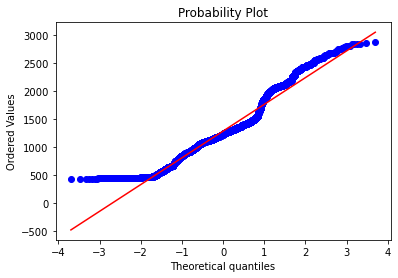

In [20]:
ss.probplot(df_data.spx, plot=pylab);

The QQ plot arranges all the values in accending order. The Y-axis expresses the price. The X-axis describes how the number of standard deviations the values are away from the mean. If the data points are on top of the red line then the data is normal distributed. Values around 500 deviate from the mean so we can concluse the the data is not follow the normal distribution. Therefore, we cannot use the nice properties of the normal distribution to make forecasts. More often than not, time series data is not normal distributed.

## Splitting Data

We cannot shuffle time series data so we define a cut-off time to make the train/test splits.

In [21]:
N_train_set = int(np.ceil(len(df_data) * 0.8))

In [22]:
N_train_set

5022

In [23]:
df_train = df_data.iloc[:N_train_set]

In [24]:
df_test = df_data.iloc[N_train_set:]